From QuantEcon Infinite Horizon Dynamic Programming

Bellman Functional Equation for a consumption-investment problem without risk and without labor

\begin{align*}
v(k)  &= \ max_{c,k'} \ \ u(c) + \beta v(k') \\
c &= f(k) + (1-\delta) k - k'
\end{align*}

Below, the value function iteration is computed in two ways:

#### 1) maximization over a grid (discrete dynamic programming)

Since $u$ is a function whereas $v$ is stored over a grid, it is more convenient to maximize over $k'$ rather than over $c$. (Otherwise, to maximize over $c$ we would need to make sure that $k' = f(k) - c + (1-\delta) k$ is on the grid, or interpolate $v$.)
\begin{equation*}
v(k) = \max_{k' \in \text{grid}} u(f(k) - k' + (1-\delta) k) + \beta v(k')
\end{equation*}
where if the grid is $[k_0, k_1]$, consumption is constructed:
\begin{equation*}
C = 
\left[
\begin{array}{cc}
f(k_0) & f(k_0)\\
f(k_1) & f(k_1)
\end{array}
\right]
- \left[
\begin{array}{cc}
k_0 & k_1\\
k_0 & k_1
\end{array}
\right]
+ (1- \delta)
\left[
\begin{array}{cc}
k_0 & k_0\\
k_1 & k_1
\end{array}
\right]
\end{equation*}
- Rows represent different values of $k$.
- Columns represent different values of $k'$.
- Since we are maximizing over $k'$, the program will maximize over the second axis (indexed 1).

#### 2) maximization after interpolation of v:
Since $v$ is a function (once interpolated), it is more convenient to maximize over $c$ rather than $k'$.
\begin{equation*}
v(k) = \max_{1e^{-9} \leq c \leq f(k) + (1-\delta) k} u(c) \ + \ \beta \ v(f(k) - c + (1-\delta) k)
\end{equation*}


## 1) Value Function Iteration: maximization over a grid (discrete dynamic programming)
###Consumption-investment without risk
#### Discrete Dynamic Programming

In [1]:
"""
Filename: Bellman Operator from QuantEcon
Author : Guillaume M Sublet
August 18, 2015, UMN Minneapolis
"""
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import log
from scipy.optimize import fminbound
from scipy import interpolate
from scipy import interp

def ValueFunctionIterator_consumption_investment(v, u, beta, f, delta, n, k):
    """
    Bellman_consumption_saving operator for a consumption-saving problem
    Note that this operator does not interpolate, it maximizes on a grid.
    v is the initial guess of value function
    u is the utility function of the consumer
    beta is the discount factor
    f is the production function
    delta is the depreciation rate
    n is the size of the grid
    k is the grid of possible levels of capital
    """
    C = np.tile(f(k), (1, n)) - np.tile(k.T, (n, 1)) + (1 - delta) * np.tile(k, (1, n)) # Possible consumption levels
    C[C< 1e-6] = 1e-6 # To satisfy the constraint that consumption has to be positive.
    U = u(C) # Utility levels
    U[C< 1e-9] = -np.infty #to address the fact that the utility is bounded below
    VP = U + beta * np.tile(v, (n, 1))
    vprime = np.nanmax(VP, axis = 1)
    return vprime

def value_function_iteration(max_iter, tol, v, u, beta, f, delta, n, k):
    """
    Note that this operator does not interpolate, it maximizes on a grid.
    max_iter: maximum number of iteration
    tol: criterion below which we claim convergence
    v: variable of the functional equation which converges
    u, beta, f, delta, n, k: arguments of the iterator
    """
    dist = tol + 1
    for it in range(max_iter):
        vprime = ValueFunctionIterator_consumption_investment(v, u, beta, f, delta, n, k)
        dist = np.max(np.absolute(v - vprime)) #supremum norm of the difference between two subsequent value functions
        v = vprime #update the guess
        if dist < tol:
            print it, '= number of iterations. Converged'
            return vprime
            break
    else:
        print 'not converged'
        return vprime

def Policies_consumption_investment(w, u, beta, f, delta, n, k):
    """
    Obtains a pair of n dimensional policy vectors for a consumption and saving
    w is the initial guess of value function
    u is the utility function of the consumer
    beta is the discount factor
    f is the production function
    delta is the depreciation rate
    n is the size of the grid
    k is the grid of possible levels of capital
    """
    C = np.tile(f(k), (1, n)) - np.tile(k.T, (n, 1)) + (1 - delta) * np.tile(k, (1, n)) # Possible consumption levels
    C[C< 1e-7] = 1e-7 # To satisfy the constraint that consumption has to be positive.
    U = u(C) # Utility levels
    U[C< 1e-6] = -1e10 #to address the fact that the utility is bounded below
    VP = U + beta * np.tile(w, (n, 1))
    index_max = VP.argmax(axis = 1)
    policy_capital = k[index_max]
    policy_consumption = np.array(f(k)) - policy_capital
    return [policy_consumption, policy_capital]


def policy_path(T, k_init, policy):
    """
    Returns the path of the state variable over T periods, starting from k_init and applying policy iteratively
    T: length of the vector returned
    k_init: initial level of the state variable
    policy: policy that determines the state variable next period
    """
    path = np.empty(T) 
    path[0] = k_init
    policy_resized = policy
    policy_resized.shape = (n,)
    k_resized = k
    k_resized.shape = (n,)
    policy = interpolate.interp1d(k_resized, policy)
    for i in range(T-1):
        path[i+1] = policy(path[i])
    return path

In [2]:
#Parameters
tol = 1e-10 #Tolerance level below which convergence is considered done
max_iter = 560 #Maximum number of iterations
n = 50 #number of grid points
grid_min = 1e-6 #grid_min, grid_max : minimum and maximum points of the grid
grid_max = 3
alpha = 0.65 #Coefficient of the Cobb-Douglas production technology
theta = 1 #Total Factor Productivity
beta = 0.95 #Patience parameter
delta = 1 #Depreciation rate
# Grid
k = np.linspace(grid_min, grid_max, n)
k.shape = (n, 1)


# Production technology
def f(x):
    return theta * x**(alpha)
# Utility function
def u(x):
    return log(x)

"""
Exact solution for the case with
    - full depreciation delta = 1,
    - log utility, 
    - Cobb-Douglas utility: theta = 1 and f(x)=theta*x**alpha
"""
c_1 = log(1 - alpha * beta)/(1 - beta) + log(alpha * beta) * alpha * beta / ((1 - alpha * beta) * (1 - beta))
c_2 = alpha / (1 - alpha * beta)
def v_star(k):
    return c_1 + c_2 * log(k)
vstar = np.array(v_star(k))
def policy_star(k):
    return (1- alpha * beta) * k**alpha
consumptionstar = np.array(policy_star(k))

""" 
Value Function Iteration
"""
init_v = np.linspace(0,100,n) # Initial guess of value function
init_v.shape = (1, n)
v = value_function_iteration(max_iter, tol, init_v, u, beta, f, delta, n, k)

"""
Obtain the policy functions
"""
[policy_consumption, policy_capital] = Policies_consumption_investment(v, u, beta, f, delta, n, k)

485 = number of iterations. Converged


In [ ]:
# If we wanted to record the loops:
'''
Value Function Iteration

V = []  # record of the sequence of value functions
dist = 10 #initial distance
init_v = np.linspace(0,100,n) # Initial guess of value function
init_v.shape = (1, n)

while dist > tol: #apply the contraction iteratively until it converges
    vprime = ValueFunctionIterator_consumption_investment(init_v, u, beta, f, delta, n, k)
    ax0.plot(k, vprime, 'r--', linewidth=0.9, label='exact solution', alpha=0.9) # plot sequence of value functions
    dist = np.max(np.absolute(v - vprime)) #supremum norm of the difference between two subsequent value functions
    init_v = vprime #update the guess
    V.append(vprime)
'''

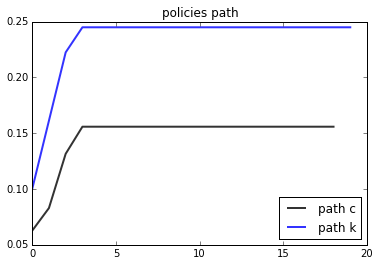

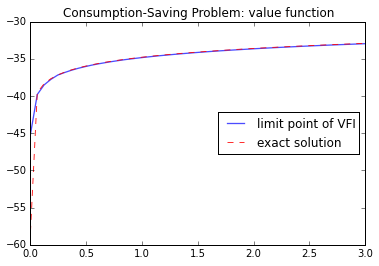

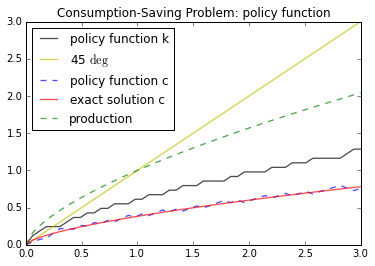

In [3]:
"""
Compute a time path of capital
"""
T = 20
k_init_k = 0.1
path_c = np.zeros(T-1)

path_k = policy_path(T, k_init_k, policy_capital)
for i in range(T-1):  # Note that the state variable is capital, not consumption, 
    # it would be wrong to compute the path of consumption by iteratively applying 
    # the consumption policy function since the policy function is a function of capital.
    path_c[i] = path_k[i]**alpha - path_k[i+1]

"""
Figures
"""
# Time path of capital and consumption
fig, ax = plt.subplots()
ax.set_xlim(0, T)
ax.plot(range(len(path_c)), path_c, 'k-', lw=2, alpha=0.8, label='path c')
ax.plot(range(len(path_k)), path_k, 'b-', lw=2, alpha=0.8, label='path k')
ax.legend(loc='lower right')
ax.set_title('policies path')

# Value functions: exact and fixed point of Bellman Functional equation
fig, ax0 = plt.subplots()
ax0.plot(k, v, 'b-', linewidth=1.3, label='limit point of VFI', alpha=0.7)
ax0.plot(k, vstar, 'r--', linewidth=0.9, label='exact solution', alpha=0.9)
ax0.legend(loc='center right')
ax0.set_title('Consumption-Saving Problem: value function')
ax0.set_ylim(-60, -30)
ax0.set_xlim(np.min(k), np.max(k))

# Comparison of exact and v-greedy policy functions
fig, ax1 = plt.subplots()
ax1.plot(k, policy_capital, 'k-', linewidth=1.3, label='policy function k', alpha=0.7)
ax1.plot(k, k, 'y-', linewidth=1.3, label='45 $\deg$', alpha=0.7)
ax1.plot(k, policy_consumption, 'b--', linewidth=1.3, label='policy function c', alpha=0.7)
ax1.plot(k, consumptionstar, 'r-', linewidth=1.3, label='exact solution c', alpha=0.7)
ax1.plot(k, np.array(f(k)), 'g--', linewidth=1.3, label='production', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Consumption-Saving Problem: policy function')
plt.show()

## 2) Value Function Iteration: maximization after interpolation of v
###consumption-investment without risk
#### Linear Interpolation

The code below is copied from Quantecon and modified to answer Exercise 1 from Quantecon, Infinite Horizon Dynamic Programming

In [5]:
"""
Filename: Bellman Operator from QuantEcon
Author : Guillaume M Sublet
August 18, 2015, UMN Minneapolis
"""

from __future__ import division  # Omit for Python 3.x
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import log
from scipy.optimize import fminbound
from scipy import interpolate

def bellman_operator_interp(w):
    """
    Fom QuantEcon website
    The approximate Bellman operator, which computes and returns the updated value function Tw on the grid points.
        * w is a flat NumPy array with len(w) = len(grid)
    The vector w represents the value of the input function on the grid points.
    Note that this operator interpolates linearly before maximizing.
    """
    # === Apply linear interpolation to w === #
    Aw = lambda x: interp(x, grid, w)
    # === set Tw[i] equal to max_c { log(c) + beta w(f(k_i) - c)} === #
    Tw = np.empty(grid_size)
    Cw = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        c_star = fminbound(objective, 1e-6, k**alpha) # 1e-6, k**alpha are the bounds of optimization
        Tw[i] = - objective(c_star)
        Cw[i] = c_star
    return [Tw, Cw]

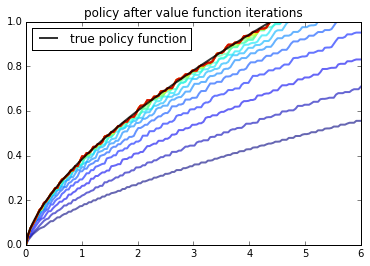

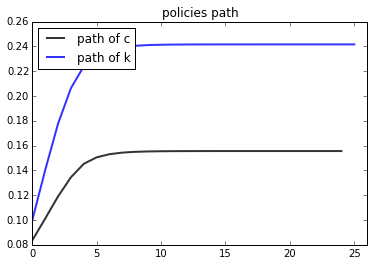

In [6]:
'''
Environment
'''
# Primitives and grid
alpha = 0.65
beta = 0.95
grid_max = 6
grid_size = 150
grid = np.linspace(1e-8, grid_max, grid_size)

'''
Exact solution
'''
ab = alpha * beta
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)

def v_star(k):
    return c1 + c2 * log(k)
def policy_star(k):
    return (1- alpha * beta) * k**alpha
consumptionstar = np.array(policy_star(grid))


'''
Main loop
'''
# === If file is run directly, not imported, produce figure === #
if __name__ == '__main__':
    for p in [20]:
        w = 5 * log(grid) - 25  # An initial condition -- fairly arbitrary
        n = p
#        fig, ax = plt.subplots()
#        ax.set_ylim(-50, -30)
#        ax.set_xlim(np.min(grid), np.max(grid))
#        lb = 'initial condition'
#        ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
        fig, ax1 = plt.subplots()
        ax1.set_xlim(np.min(grid), np.max(grid))
        ax1.set_ylim(0, 1)
        for i in range(n):
            [w, c] = bellman_operator_interp(w)
#            ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
            ax1.plot(grid, c, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
#        lb = 'true value function'
#        ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
        ax1.plot(grid, policy_star(grid), 'k-', lw=2, alpha=0.8, label='true policy function')
        ax1.legend(loc='upper left')
        ax1.set_title('policy after value function iterations')
        plt.show()
        
if __name__ == '__main__':
    T = 25
    path_k = np.zeros(T+1)
    path_c = np.zeros(T)    
    path_k[0] = 0.1
    K = grid**alpha - c
    K_interp = lambda x: interp(x, grid, K)
    for i in range(T):
        path_k[i+1] = K_interp(path_k[i])
        path_c[i] = path_k[i]**alpha - path_k[i+1]
        
    fig, ax3 = plt.subplots()
    ax3.set_xlim(0, T+1)
    ax3.plot(range(len(path_c)), path_c, 'k-', lw=2, alpha=0.8, label='path of c')
    ax3.plot(range(len(path_k)), path_k, 'b-', lw=2, alpha=0.8, label='path of k')
    ax3.legend(loc='upper left')
    ax3.set_title('policies path')
    plt.show()